# Face Generation

Student: Angel Martinez-Tenor <br/>
Deep Learning Nanodegree Foundation - Udacity <br/>
May 13, 2017 <br/>

In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

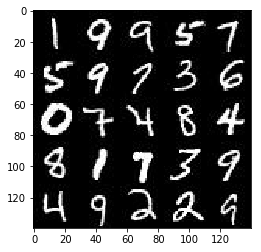

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

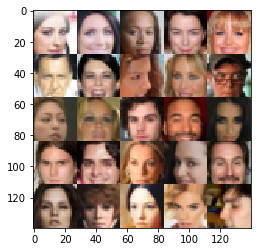

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # EXERCISE: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learing_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # EXERCISE: Implement Function
    
    # Adapted from DCGAN.ipynb Discriminator. Number of Convolutional layers tested: 2-3
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x1 (MNIST) or 28x28x3 (ceb faces)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128  
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
#       # 4x4x256   

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # EXERCISE: Implement Function
    
    # Adapted from DCGAN.ipynb Generator. Number of Convolutional layers tested: 2-3
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x1 (MNIST) or 28x28x3 (ceb faces)  now
        
        out = tf.tanh(logits)
        
        return out    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # EXERCISE: Implement Function
    
    # Adapted from DCGAN.ipynb Model Loss
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    soft = 0.9 # one-sided label smoothing

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*soft))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)*soft))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # EXERCISE: Implement Function
    
    # From DCGAN.ipynb Optimizers
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    # 'with tf.control_dependencie' is required for bacth normalization
    #  https://github.com/udacity/deep-learning/blob/master/batch-norm/Batch_Normalization_Lesson.ipynb
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt  
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    #example_z = np.random.normal(1, 1, size=[n_images, z_dim])


    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # EXERCISE: Build Model
    
    # Adapted from DCGAN.ipynb Building the model, GAN class

    # tf.reset_default_graph() cannot be used here as train is called within tf.Graph().as_default()
    
    #print(data_shape)
    assert ((data_image_mode == "L" and data_shape[3] == 1) or 
            (data_image_mode == "RGB" and data_shape[3] == 3)), \
            ("Image mode Inconsistency: ", data_image_mode, " mode, ", data_shape[2], " channels")
    out_channel_dim = data_shape[3]    
        
    input_real, input_z, lr_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_placeholder, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        samples, losses = [], []
        steps = 0
        show_every = 100
        print_every = 30
        sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
        # sample_z = np.random.normal(0, 1, size=(50, z_dim))
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # EXERCISE: Train Model
                
                # Adapted from DCGAN.ipynb Building the model, train function
                
                steps += 1

                batch_images *= 2  # From [-0.5,0.5] to -[1,1]
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #batch_z = np.random.normal(0, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_placeholder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr_placeholder: learning_rate, input_real: batch_images})
                    # 2x generator optimizer as suggested in the forum
                # _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr_placeholder: learning_rate}) 

                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr_placeholder: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr_placeholder: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                          
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)                  

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.2382... Generator Loss: 0.5772
Epoch 1/2... Discriminator Loss: 3.2432... Generator Loss: 0.3491
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 1.3028


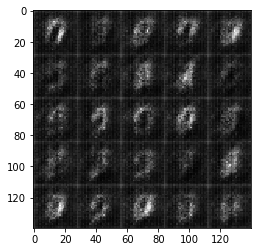

Epoch 1/2... Discriminator Loss: 1.7167... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.5171
Epoch 1/2... Discriminator Loss: 1.6069... Generator Loss: 0.4630


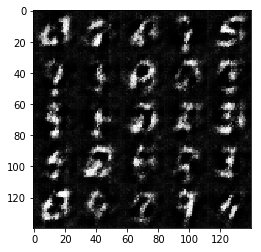

Epoch 1/2... Discriminator Loss: 1.8403... Generator Loss: 0.3827
Epoch 1/2... Discriminator Loss: 1.9425... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 0.7736
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 0.5015


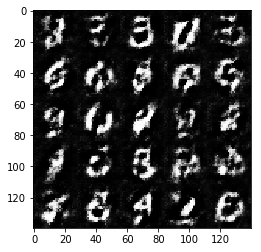

Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 0.7944
Epoch 1/2... Discriminator Loss: 1.5913... Generator Loss: 0.4377
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.5355


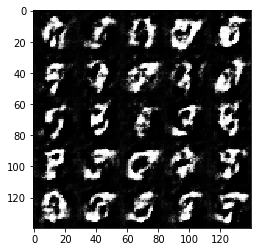

Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 1.0749


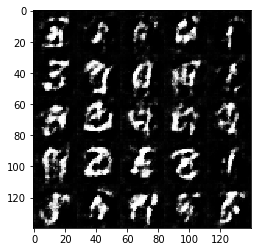

Epoch 1/2... Discriminator Loss: 1.7747... Generator Loss: 0.4129
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 2.8302
Epoch 1/2... Discriminator Loss: 1.5915... Generator Loss: 2.6766
Epoch 1/2... Discriminator Loss: 1.7915... Generator Loss: 0.4160


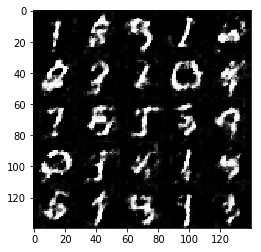

Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.7159
Epoch 1/2... Discriminator Loss: 1.8502... Generator Loss: 0.3922


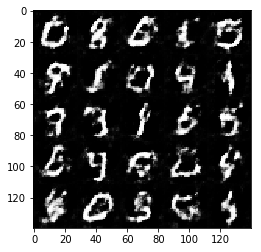

Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 1.7073... Generator Loss: 0.4075
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.7591


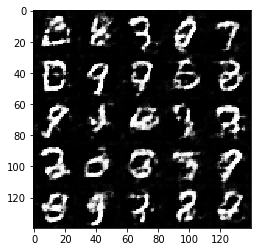

Epoch 1/2... Discriminator Loss: 0.8872... Generator Loss: 1.5923
Epoch 1/2... Discriminator Loss: 0.7361... Generator Loss: 2.2310
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.6736
Epoch 1/2... Discriminator Loss: 0.9259... Generator Loss: 0.8809


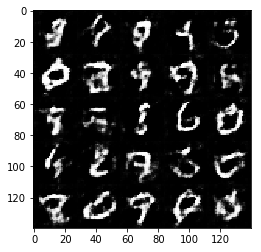

Epoch 1/2... Discriminator Loss: 0.9165... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 1.0855... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.5673


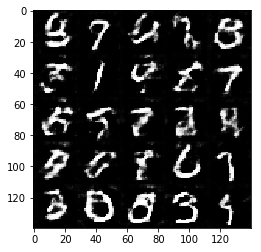

Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 1.4743
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 2.3204


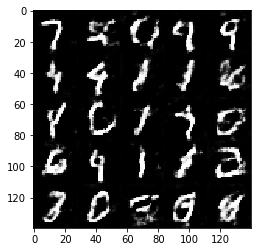

Epoch 1/2... Discriminator Loss: 1.1745... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.5579


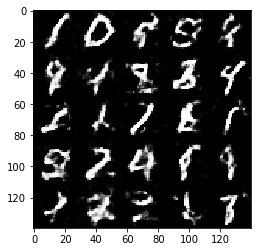

Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.7893


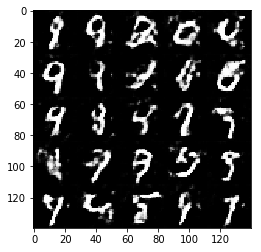

Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.1835
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 0.5719
Epoch 1/2... Discriminator Loss: 1.6734... Generator Loss: 0.4487


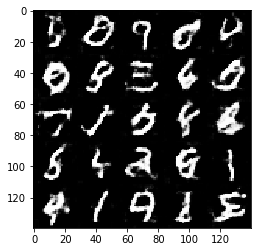

Epoch 1/2... Discriminator Loss: 1.1112... Generator Loss: 0.6581
Epoch 1/2... Discriminator Loss: 0.6863... Generator Loss: 1.3110
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 0.8014... Generator Loss: 1.7392


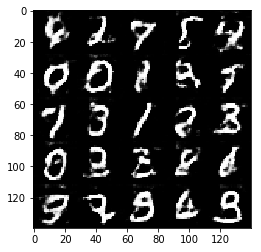

Epoch 1/2... Discriminator Loss: 1.7600... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 0.9705... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.6367


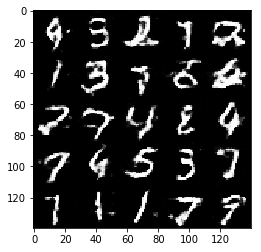

Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 3.0719
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.5878
Epoch 1/2... Discriminator Loss: 1.8534... Generator Loss: 2.7137


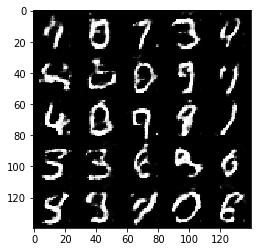

Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 1.1124
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 1.1620
Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 0.8519


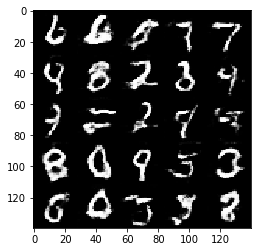

Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 1.5960... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.2250


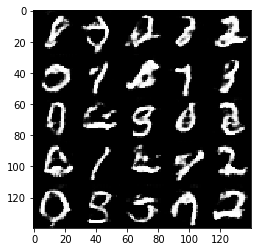

Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 1.2054


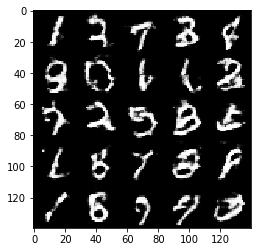

Epoch 2/2... Discriminator Loss: 1.6821... Generator Loss: 0.5033
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.9968
Epoch 2/2... Discriminator Loss: 0.7495... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 0.7863


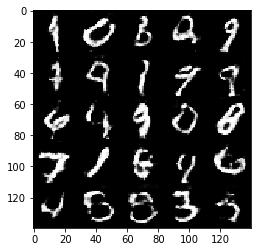

Epoch 2/2... Discriminator Loss: 0.7680... Generator Loss: 2.9383
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.6278


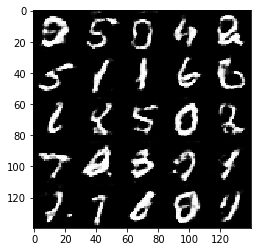

Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 1.2834
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 1.5780
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.5825


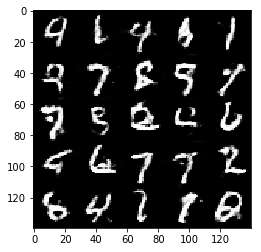

Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.0955
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 0.9803
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.5769


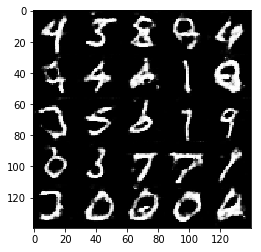

Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 2.1291
Epoch 2/2... Discriminator Loss: 0.6016... Generator Loss: 1.7194
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 0.6935


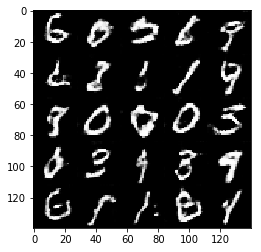

Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 2.3032
Epoch 2/2... Discriminator Loss: 0.5452... Generator Loss: 1.6824
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 0.9736


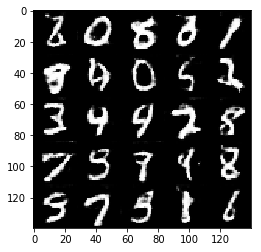

Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.6781
Epoch 2/2... Discriminator Loss: 0.6959... Generator Loss: 1.2318
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 2.0790
Epoch 2/2... Discriminator Loss: 1.7830... Generator Loss: 0.4485


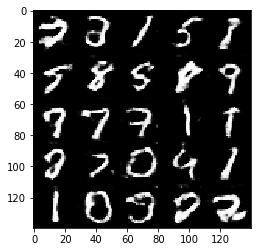

Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 1.7407
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 1.0115
Epoch 2/2... Discriminator Loss: 0.6298... Generator Loss: 1.4252


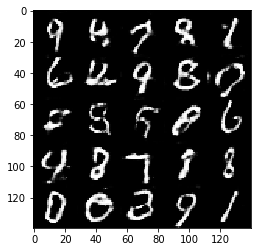

Epoch 2/2... Discriminator Loss: 0.5313... Generator Loss: 1.6201
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.1969
Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 1.9172


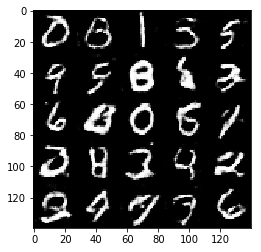

Epoch 2/2... Discriminator Loss: 0.9142... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.0342
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 1.3179
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 0.6855


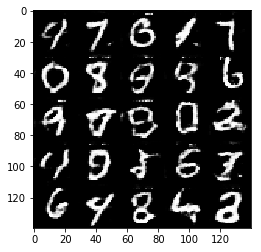

Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 0.8367
Epoch 2/2... Discriminator Loss: 0.9778... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.7781


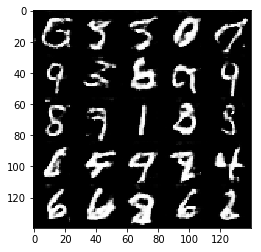

Epoch 2/2... Discriminator Loss: 0.7383... Generator Loss: 1.2065
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.5416


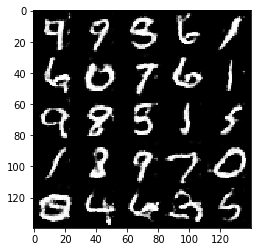

Epoch 2/2... Discriminator Loss: 0.8967... Generator Loss: 1.0830
Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.8399
Epoch 2/2... Discriminator Loss: 1.7005... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 0.8763


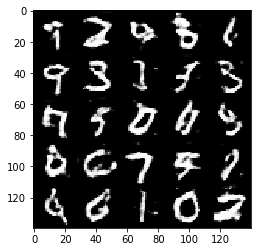

Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 1.9104
Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 0.6302... Generator Loss: 2.5859


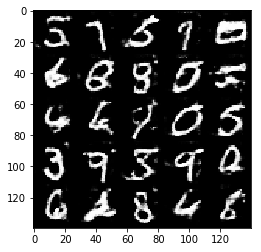

Epoch 2/2... Discriminator Loss: 0.6951... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.1046
Epoch 2/2... Discriminator Loss: 0.6306... Generator Loss: 2.2901


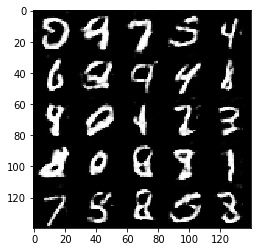

Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 0.6903... Generator Loss: 1.2975
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 2.0891
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.3543


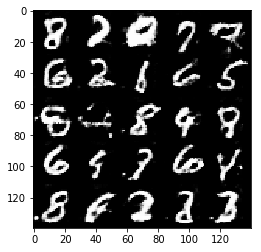

Epoch 2/2... Discriminator Loss: 0.5590... Generator Loss: 1.6346
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.5344
Epoch 2/2... Discriminator Loss: 0.5104... Generator Loss: 2.3592


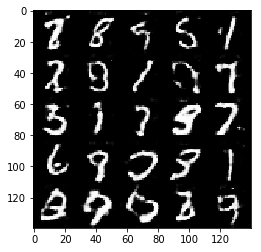

Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 1.4244
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.3481


In [12]:
batch_size = 32        # tested from 32 to 256
z_dim = 100            # tested from 50 to 200
learning_rate = 0.0002 # tested from 0.00001 to 0.02  
beta1 = 0.1            # tested from 0.01 to 0.7

# Note: The parameters have been tuned to generate accurate handwritten digits. 
#  Lower generator losses can be achieved with worse images.   

tf.reset_default_graph()  # added

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8329... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 1.9068... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 2.5310... Generator Loss: 8.4453


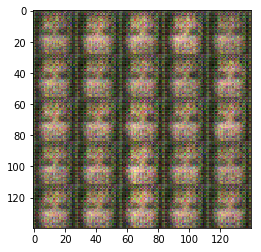

Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 3.1674
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.6615... Generator Loss: 0.4417


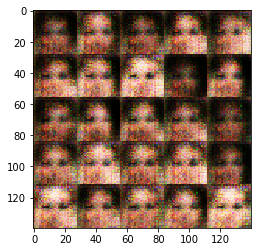

Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.4861
Epoch 1/1... Discriminator Loss: 2.0338... Generator Loss: 0.3646


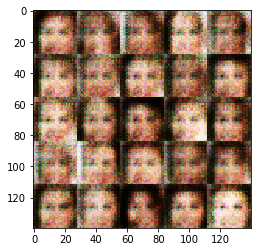

Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.7867


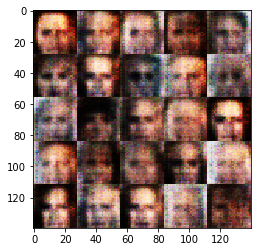

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.3151
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.0445


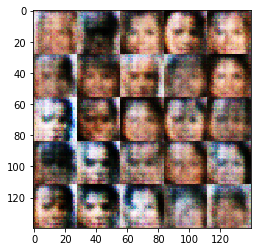

Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.7740... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 1.3496


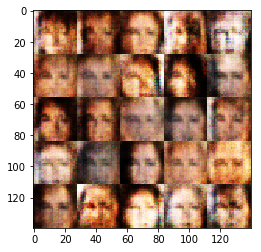

Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.4543


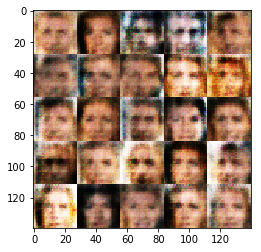

Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.4652
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4968


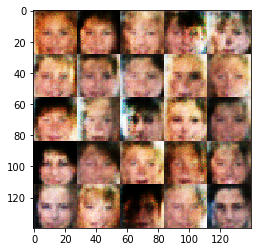

Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6695


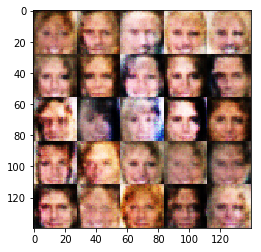

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.1364
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.1204


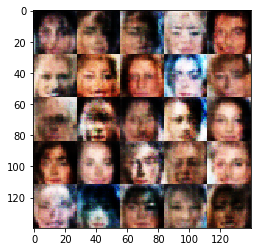

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6308


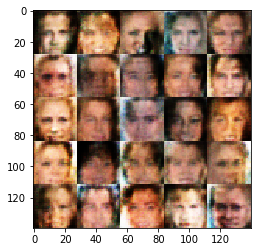

Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.8038... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.5545


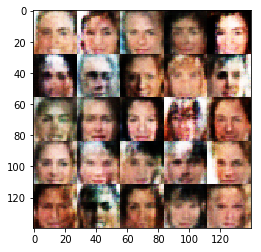

Epoch 1/1... Discriminator Loss: 1.7026... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.8359


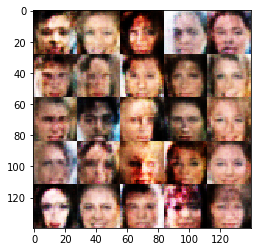

Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.1567


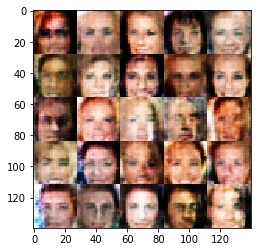

Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 2.1507... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.0862


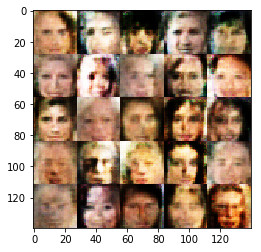

Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.0406
Epoch 1/1... Discriminator Loss: 1.9885... Generator Loss: 0.3780
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8600


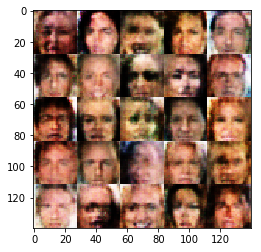

Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 2.2557
Epoch 1/1... Discriminator Loss: 1.8464... Generator Loss: 1.7752
Epoch 1/1... Discriminator Loss: 1.9213... Generator Loss: 2.0753


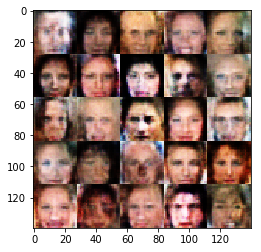

Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.8141
Epoch 1/1... Discriminator Loss: 1.7372... Generator Loss: 0.4165


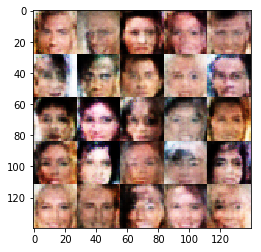

Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.1254


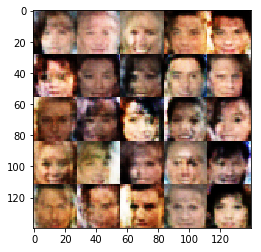

Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.6974
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 1.6702... Generator Loss: 0.4252


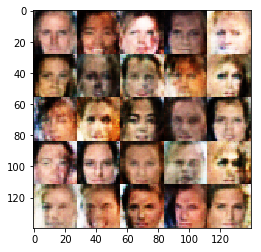

Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.5543


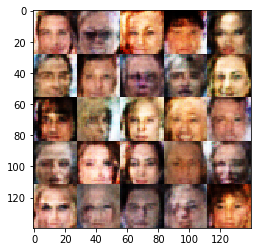

Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.4687


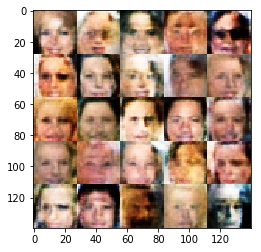

Epoch 1/1... Discriminator Loss: 1.6575... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 1.6532... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.2100


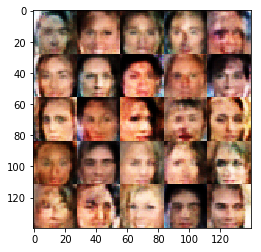

Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.5165


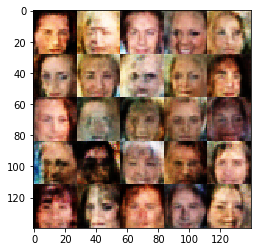

Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 1.4614
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.5612


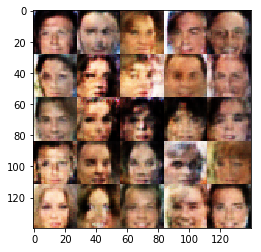

Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8461


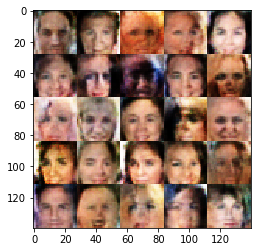

Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 0.4127


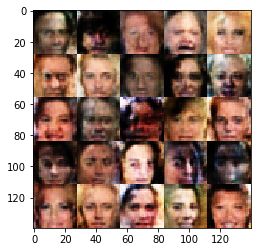

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8094


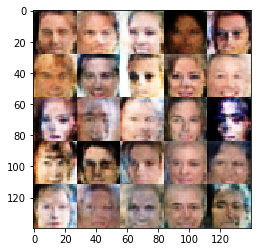

Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 2.0054... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.8627


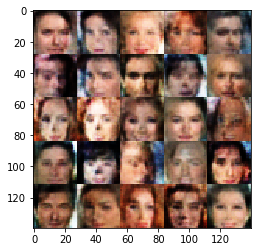

Epoch 1/1... Discriminator Loss: 1.7568... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 1.7170
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.5835


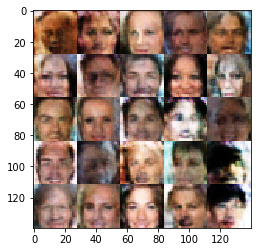

Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.9200... Generator Loss: 0.3675


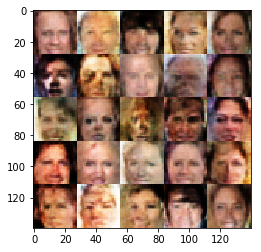

Epoch 1/1... Discriminator Loss: 2.3099... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.8606... Generator Loss: 0.3791


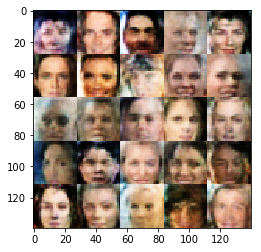

Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.4397
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.3004


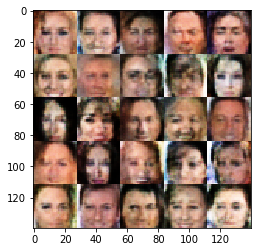

Epoch 1/1... Discriminator Loss: 1.6548... Generator Loss: 0.4503
Epoch 1/1... Discriminator Loss: 2.6773... Generator Loss: 2.8027
Epoch 1/1... Discriminator Loss: 2.4530... Generator Loss: 0.3324


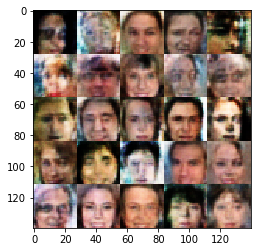

Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.3002
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.3881
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.5160


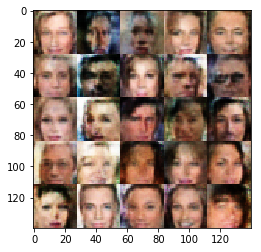

Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.7876
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 2.7604


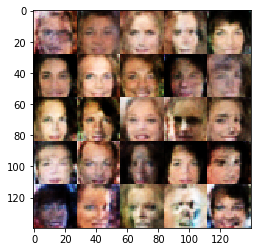

Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.5236
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 2.3383
Epoch 1/1... Discriminator Loss: 1.5992... Generator Loss: 0.4432


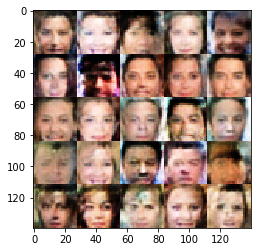

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 3.2920
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.4226


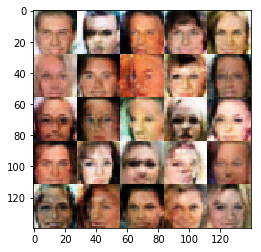

Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 1.7871
Epoch 1/1... Discriminator Loss: 2.3041... Generator Loss: 2.0783
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.6889


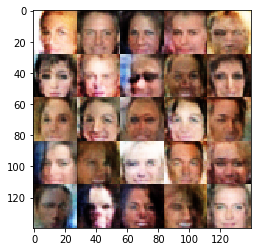

Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 2.5450
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.5400
Epoch 1/1... Discriminator Loss: 2.2733... Generator Loss: 0.3515


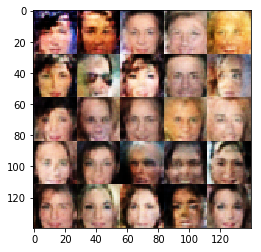

Epoch 1/1... Discriminator Loss: 2.0900... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 2.6026
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 3.0447


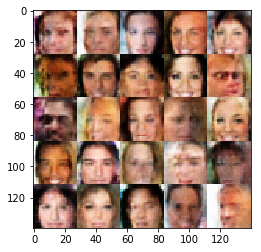

Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 2.2254... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 2.2318
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.4768


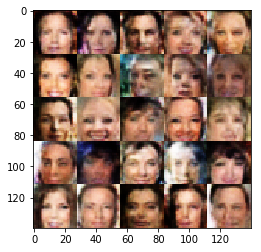

Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 1.9777... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 2.2188... Generator Loss: 0.3554


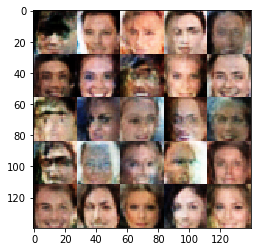

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 2.2407
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 1.6280


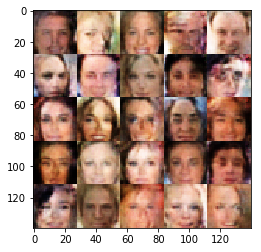

Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 2.8982
Epoch 1/1... Discriminator Loss: 2.6281... Generator Loss: 0.3318
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 0.6272... Generator Loss: 1.9039


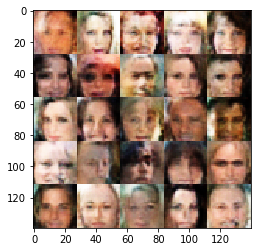

Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.9416... Generator Loss: 0.3717


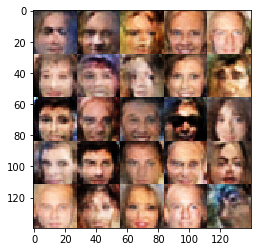

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 2.5670


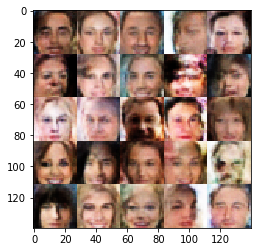

Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 2.9160
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.9276


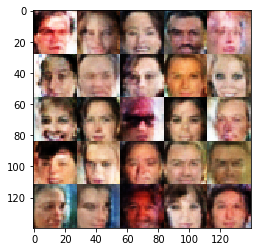

Epoch 1/1... Discriminator Loss: 2.0346... Generator Loss: 0.3705
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.2447


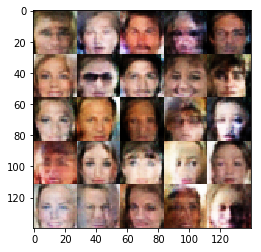

Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.6470... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.3489


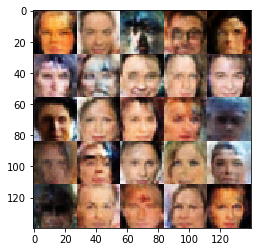

Epoch 1/1... Discriminator Loss: 1.9548... Generator Loss: 0.3670
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.2383
Epoch 1/1... Discriminator Loss: 1.9796... Generator Loss: 0.3835


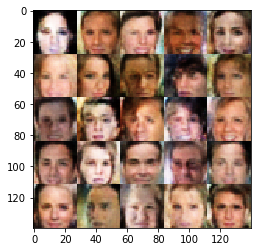

Epoch 1/1... Discriminator Loss: 1.8094... Generator Loss: 0.4061
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.8330


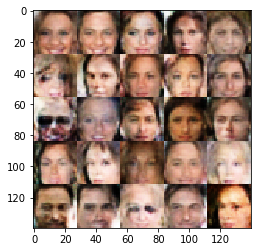

Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 0.6084... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 2.1327


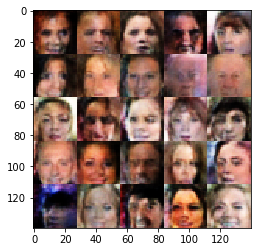

Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 0.8759... Generator Loss: 1.5976
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.6497


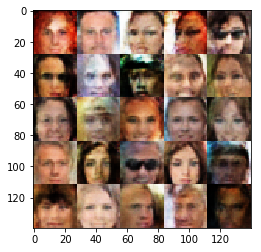

Epoch 1/1... Discriminator Loss: 2.5498... Generator Loss: 0.3345
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.4062
Epoch 1/1... Discriminator Loss: 2.5667... Generator Loss: 0.3357


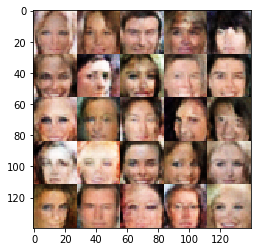

Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.6201


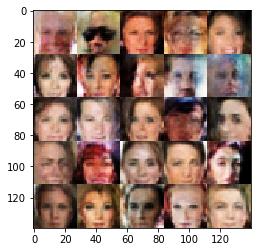

Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.4523
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 2.2796
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.4182


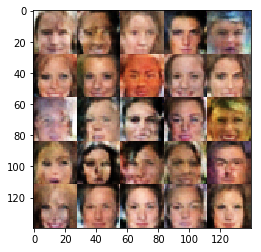

Epoch 1/1... Discriminator Loss: 1.8904... Generator Loss: 3.3834
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 1.7002


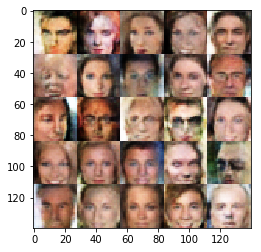

Epoch 1/1... Discriminator Loss: 1.7824... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.2906


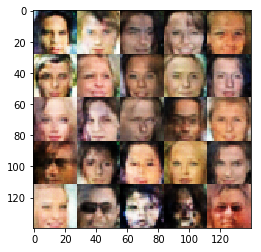

Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 2.4783
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 2.0486... Generator Loss: 2.6836


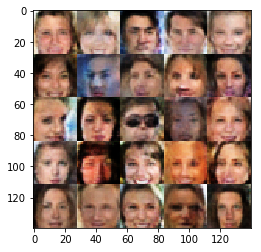

Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.8302
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.7281


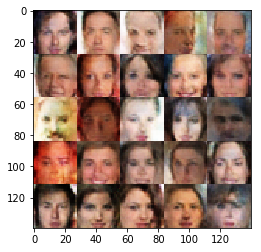

Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 2.3415... Generator Loss: 0.3421


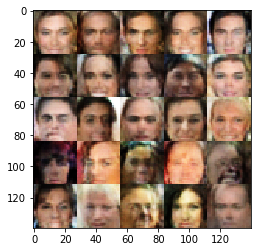

Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.7373... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.8948


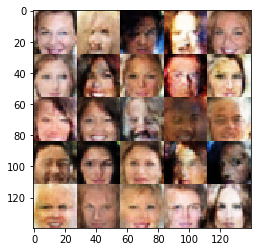

Epoch 1/1... Discriminator Loss: 1.0806... Generator Loss: 0.7065


In [13]:
batch_size = 32        # tested from 32 to 256         
z_dim = 100            # tested from 50 to 200
learning_rate = 0.0002 #tested from 0.00001 to 0.02
beta1 = 0.1            # tested from 0.01 to 0.7

tf.reset_default_graph() # added

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.